<a href="https://colab.research.google.com/github/alif-munim/AR-Examples/blob/master/imagen_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# ! pip install imagen_pytorch

In [1]:
import torch
from imagen_pytorch import Unet3D, ElucidatedImagen, ImagenTrainer

unet1 = Unet3D(dim = 64, dim_mults = (1, 2, 4, 8)).cuda()

unet2 = Unet3D(dim = 64, dim_mults = (1, 2, 4, 8)).cuda()

# elucidated imagen, which contains the unets above (base unet and super resoluting ones)

imagen = ElucidatedImagen(
    unets = (unet1, unet2),
    image_sizes = (64, 112),
    random_crop_sizes = (None, 16),
    num_sample_steps = 10,
    cond_drop_prob = 0.1,
    sigma_min = 0.002,                          # min noise level
    sigma_max = (80, 160),                      # max noise level, double the max noise level for upsampler
    sigma_data = 0.5,                           # standard deviation of data distribution
    rho = 7,                                    # controls the sampling schedule
    P_mean = -1.2,                              # mean of log-normal distribution from which noise is drawn for training
    P_std = 1.2,                                # standard deviation of log-normal distribution from which noise is drawn for training
    S_churn = 80,                               # parameters for stochastic sampling - depends on dataset, Table 5 in apper
    S_tmin = 0.05,
    S_tmax = 50,
    S_noise = 1.003,
).cuda()

# mock videos (get a lot of this) and text encodings from large T5

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [2]:
with open('/content/gif_descriptions.txt') as f:
    lines = f.read().splitlines() 

In [3]:
import os

f = []
gifs = []

for (dirpath, dirnames, filenames) in os.walk('/content/gifs'):
    f.extend(filenames)
    break

for filename in f:
    gifs.append(int(os.path.splitext(filename)[0]))
    
gifs = sorted(gifs)

In [17]:
# ! pip install --upgrade imageio

In [4]:
import imageio.v3 as iio
import numpy as np 
import os

In [5]:
def train_one_epoch(trainer):
  count = 0

  for gif in gifs:
    im_path = '/content/gifs/' + str(gif) + '.gif'

    im = iio.imread(im_path, index=None)
    gif_arr = np.asarray([im])
    gif_arr = np.moveaxis(gif_arr, -1, 1)
    gif_tensor = torch.from_numpy(gif_arr)
    gif_tensor = gif_tensor.to(device="cuda")

    gif_desc = [lines[count]]
    count += 1

    trainer(gif_tensor, texts = gif_desc, unet_number = 1, ignore_time = False)
    trainer.update(unet_number = 1)

    # print(f'gif path: {im_path}\ngif dimensions: {gif_arr.shape}\ngif description: {gif_desc}\n\n')
    # print(loss)

In [8]:
sample_text = lines[0]
print(sample_text)

age: 56.0, sex: F, ef: 63.2, esv: 34.6, edv: 94.0


In [6]:
trainer = ImagenTrainer(imagen)

train_one_epoch(trainer)

In [9]:
videos = trainer.sample([sample_text], video_frames = 20)

unet 2 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
videos[0].shape

torch.Size([3, 20, 112, 112])

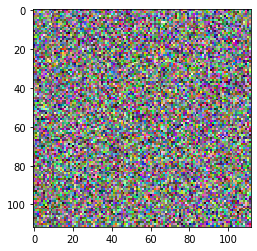

In [13]:
import numpy as np
from matplotlib import pyplot as plt

video = videos[0].cpu().detach().numpy()

video_frames = np.moveaxis(video, [0, 1], [-1, 0])

data = video_frames[0]
plt.imshow(data, interpolation='nearest')
plt.show()

In [14]:
import numpy as np
from PIL import Image

imgs = video_frames * 255
imgs = imgs.astype(np.uint8)
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=70, loop=0)


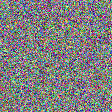

In [15]:
import base64
from IPython.core.display import display, HTML

gif_path = '/content/array.gif'

b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width="200"/>'))